### prescoring создание прескоринга
создан на основе exploratory_prescoring_part2.ipynb
Входные данные 
- data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи на target
- data/interm/accounts_status.pkl с общей категорией

In [65]:
import pandas as pd

In [66]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [67]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))

Размер считанных данных target_class with mdm features- (85798, 39)


In [68]:
name = pre + "data/interm/merge_cleaned.pkl"
df_mdm = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных фед ресурса mdm- {}".format(df_mdm.shape))

Размер считанных данных фед ресурса mdm- (1412787, 28)


In [69]:
name = pre + "data/interm/accounts_status.pkl"
accounts_status = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных о контрагентах (сводно из DWH и 1c) - {}".format(accounts_status.shape))
# accounts_status.head(1)

Размер считанных данных о контрагентах (сводно из DWH и 1c) - (737858, 4)


In [70]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/prescoring.xlsx"
writer = ExcelWriter(name)

In [71]:
# target_features.head(1)

#### Теперь формируем выборки для фрод и дефолта

In [72]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению

# target_frod.print_param()

In [73]:
# target_features.head(2)

кред дефолт у нас под хорошего попадает

In [74]:
# pd.crosstab(target_frod.data['Метка фрод дефолта'], target_frod.data['Метка кред дефолта'])
# pd.crosstab(target_frod.data['Метка дефолта'], target_frod.data['Метка кред дефолта'])

### Расчет фичи количество договоров no_contracts_total на mdm

In [75]:
contacts_total = df_mdm.groupby('new_lessee_inn')['origin_by_message'].aggregate('nunique').to_frame()\
                    .reset_index().rename(columns={'origin_by_message':'no_contracts_total'})
print(len(contacts_total))
# contacts_total.head()

227997


In [76]:
#  смотрим на статусы наших контрагентов
clients_status = pd.merge(contacts_total, accounts_status, how='left', left_on=['new_lessee_inn'], right_on=['inn'])

# определяем дубликаты по ID
num, duplicates = identify_duplicates(clients_status, 'new_lessee_inn')
Check_dupl(num, duplicates)

clients_status['Статус_контрагента'] = clients_status['Статус_контрагента'].fillna('Не является нашим клиентом')
clients_status['Статус_общ'] = clients_status['Статус_общ'].fillna('Не является нашим клиентом')
# clients_status.head()

In [77]:
df = pd.pivot_table(clients_status, index='Статус_контрагента',  values='new_lessee_inn',  aggfunc='count', margins=True, fill_value= 0)\
    .rename(columns={'new_lessee_inn':'Количество ИНН'})
df['Доля, %'] = round(df['Количество ИНН']/df['Количество ИНН']['All']*100,2)
# df

In [78]:
df = pd.pivot_table(clients_status, index='Статус_общ',  values='new_lessee_inn',  aggfunc='count', margins=True, fill_value= 0)\
    .rename(columns={'new_lessee_inn':'Количество ИНН'})
df['Доля, %'] = round(df['Количество ИНН']/df['Количество ИНН']['All']*100,2)
# df

### смотрим, есть ли они в bmd

In [79]:
clients = clients_status

# clients.sample(1)

## Обучение модели на target
### Фича no_contracts_total - "Количество договоров до дня принятия решения" на Фрод выборке

используется эта фича так как эти данные имеют наибольший AUC в однофактоной анализе LogRegression

{'rocauc': 0.67, 'accuracy': 0.48, 'recall': 0.9}
{'intercept': -0.4279, 'coef': array([-2.1668])}


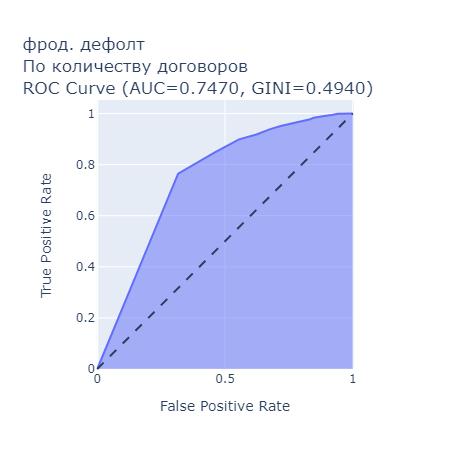

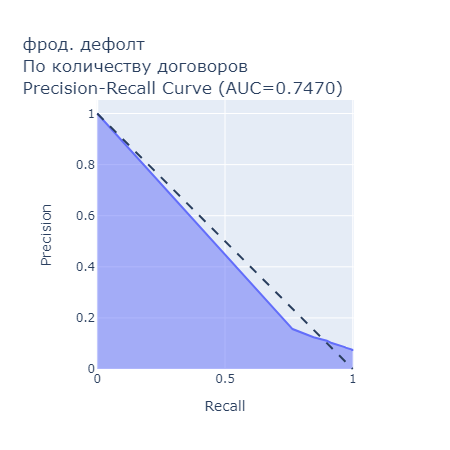

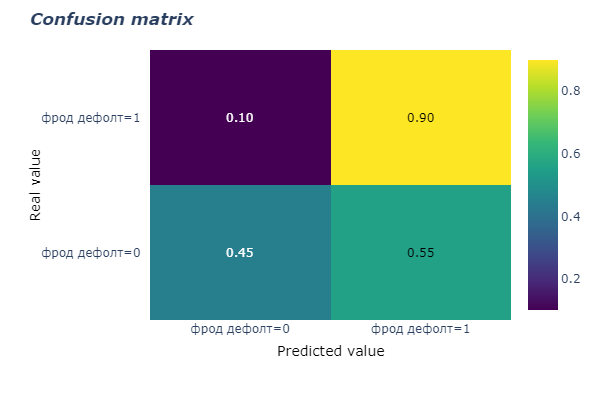

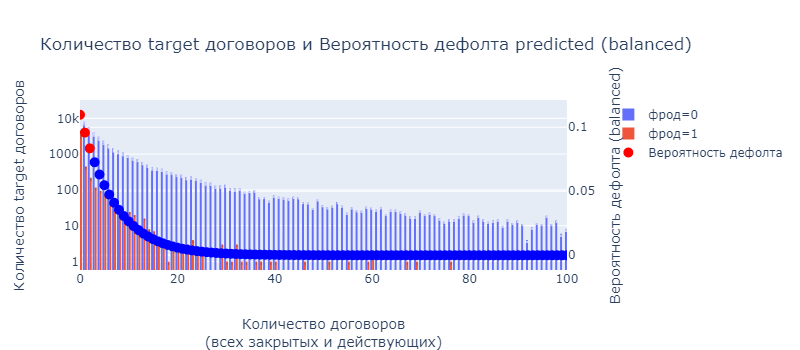

In [80]:
type = target_frod.type
classes_frod = ['фрод дефолт=0', 'фрод дефолт=1']

X_raw = np.asarray(target_frod.data[['no_contracts_total']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig_roc_auc = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству договоров')
fig_precision_recall = log.plot_precision_recall(title = '{}. дефолт'.format(type) + '<br>' +'По количеству договоров')
fig = log.plot_confusion_matrix(normalize='true', classes = classes_frod)

#  вывод исходных данных с вероятностями дефолта
y_pred, y_prob = log.predict(np.arange(0, 200))
df_second = pd.DataFrame({'X':np.arange(0, 200), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_contracts_total', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_contracts_total', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

видно, что граница принятия решения frod predicted = 0 при no_contracts_total>=3

$\sum p(дефолта|ДоговоровВсего = boundary)*p(boundary)$

### Делаем prediction на данных mdm по обученной модели balanced

In [81]:
X_raw = np.asarray(clients['no_contracts_total'])
y_pred, y_prob = log.predict(X_raw)
clients['proba'] = y_prob

#  это наша фича на mdm сохраняем для Игоря
clients[['new_lessee_inn', 'no_contracts_total', 'Статус_общ', 'is_in_bmd', 'proba']].to_pickle(pre+"data/interm/clients_mdm.pkl", compression={'method':'zip'})
# clients.head(1)

теперь построим распределение

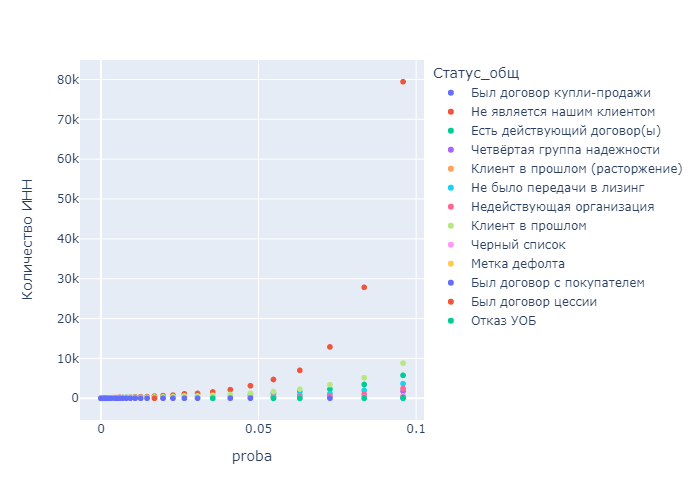

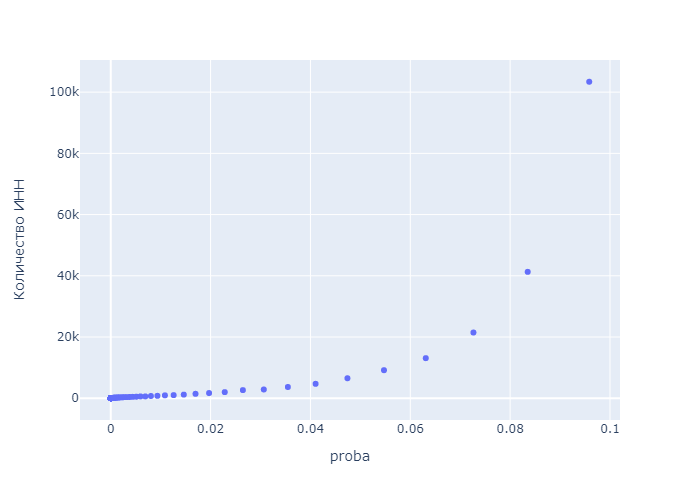

In [82]:
tmp = clients.reset_index()
df = pd.pivot_table(tmp, index=['proba', 'Статус_общ', 'no_contracts_total'], values='index', aggfunc='count', )\
            .rename(columns={'index':'Количество ИНН'}).reset_index()

fig = px.scatter(df, x='proba', y="Количество ИНН", color='Статус_общ', text='no_contracts_total')
fig.show('png' if need_svg else '')

tmp = clients.reset_index()
df = pd.pivot_table(tmp, index=['proba', 'no_contracts_total'], values='index', aggfunc='count')\
            .rename(columns={'index':'Количество ИНН'}).reset_index()

fig = px.scatter(df, x='proba', y="Количество ИНН")
fig.show('png' if need_svg else '')

## Считаем метрики качества в зависимости среза (x>=boundary) на target данных

PredictionMetrics -  класс из ML_functions.ipynb

In [83]:
target_data = target_frod.data.copy()

In [84]:
df_metrics = pd.DataFrame(columns=['boundary', 'FN', 'TN', 'FP', 'TP', 'Доля_дефолта_в_target'])
max_contracts_total = int(target_data['no_contracts_total'].max())
# max_contracts_total = 21 #  больше не надо
for boundary in tqdm(range(max_contracts_total)):
    mask = (target_data['no_contracts_total']>=boundary)
    target_data.loc[mask, 'y_pred'] = 0
    target_data.loc[~mask, 'y_pred'] = 1

    pred = PredictionMetrics(y_true=target_data['Метка дефолта'], y_pred=target_data['y_pred'])
    cm = pred.confusion_matrix(normalize='true')
    FN, TN, FP, TP = cm[0, 1], cm[1, 1], cm[1, 0], cm[0, 0]

    good = target_data[mask]
    probability = good['Метка дефолта'].sum()/len(good)

    d = {'boundary': boundary, 'FN' : FN, 'TN' : TN, 'FP' : FP, 'TP' : TP, 'Доля_дефолта_в_target':probability}
    df_metrics = df_metrics.append(d, ignore_index=True)

100%|██████████| 824/824 [00:11<00:00, 70.72it/s] 


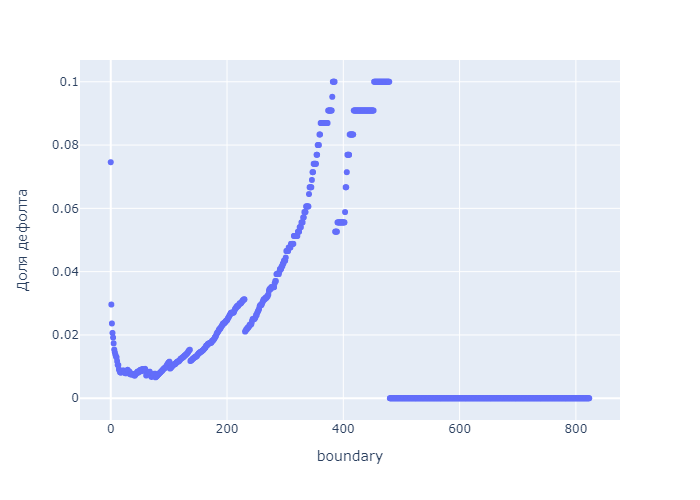

In [85]:
fig = px.scatter(df_metrics, x='boundary', y="Доля_дефолта_в_target")
fig.update_yaxes(title_text="Доля дефолта")
fig.show('png' if need_svg else '')

надо смотреть в диапазоне от 0 до 25 потом уже доля дефолта из-за маленького количества ведет себя не стабильно

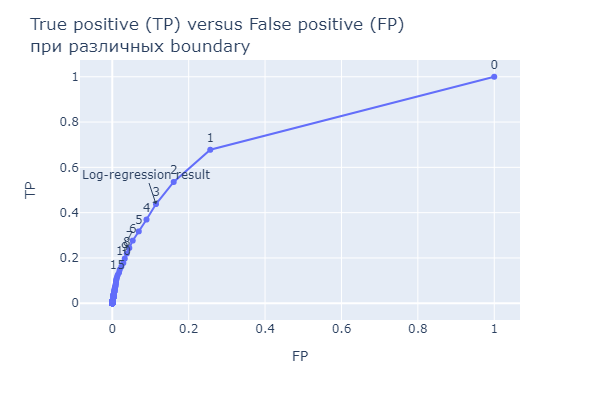

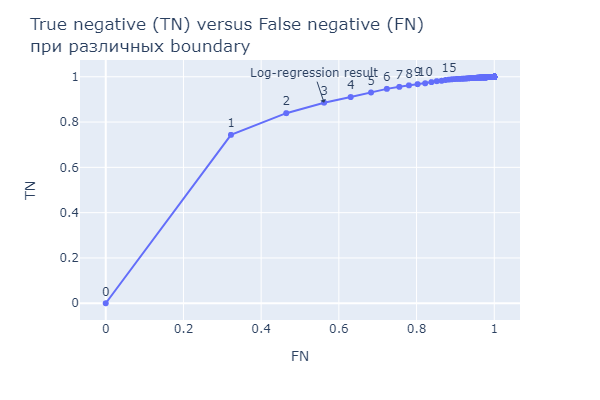

In [86]:
mask = (df_metrics['boundary']>10) & (df_metrics['boundary']%5!=0)
df_metrics.loc[mask, 'boundary_notation'] = None
df_metrics.loc[~mask, 'boundary_notation'] = df_metrics.loc[~mask, 'boundary']
df_metrics.loc[(df_metrics['boundary']>15), 'boundary_notation'] = None
# наша roc-auc
fig_FP_TP = show_depend_metrics(df_metrics, x ='FP', y = 'TP', LG_boundary = 3, title = " True positive (TP) versus False positive (FP)" + '<br>'+ "при различных boundary")
fig_FP_TP.write_html(pre+'data/html/FP-TP.html')

# FN-TN
fig_FN_TN = show_depend_metrics(df_metrics, x ='FN', y = 'TN', LG_boundary = 3, title = "True negative (TN) versus False negative (FN)" +  '<br>'+ "при различных boundary")
fig_FN_TN.write_html(pre+'data/html/FN-TN.html')

## расчет количества контрагентов в базе mdm при различных boundary

In [87]:
df_clients = pd.DataFrame(columns=['boundary', 'Количество ИНН', 'Статус_общ'])
max_contracts_total = target_data['no_contracts_total'].max()
max_contracts_total = 50 #  больше не надо

for boundary in tqdm(range(max_contracts_total)):

    mask = (clients['no_contracts_total']>=boundary)
    pre_score = clients[mask]

    df = pd.pivot_table(pre_score, index='Статус_общ',  values='new_lessee_inn', aggfunc='nunique', fill_value= 0)\
            .rename(columns={'new_lessee_inn':'Количество ИНН'}).reset_index()
    df['boundary'] = boundary
    df_clients = df_clients.append(df, ignore_index=True)

clients_w_metrics = pd.merge(df_clients, df_metrics, how='left', on=['boundary'])
clients_w_metrics['FN'] = clients_w_metrics['FN'].fillna(0.009091)
clients_w_metrics['TP'] = clients_w_metrics['TP'].fillna(0.990909)

clients_w_metrics['FN_percent'] = (clients_w_metrics['FN']*100).round(1)
clients_w_metrics['Процент_дефолта_в_target'] = (clients_w_metrics['Доля_дефолта_в_target']*100).round(2)

clients_w_metrics.sample(1) 

100%|██████████| 50/50 [00:01<00:00, 29.63it/s]


boundary Количество ИНН     Статус_общ        FN        TN        FP  \
424       36             60  Метка дефолта  0.960666  0.996177  0.003823   

           TP  Доля_дефолта_в_target  boundary_notation  FN_percent  \
424  0.039334               0.007772                NaN        96.1   

     Процент_дефолта_в_target  
424                      0.78

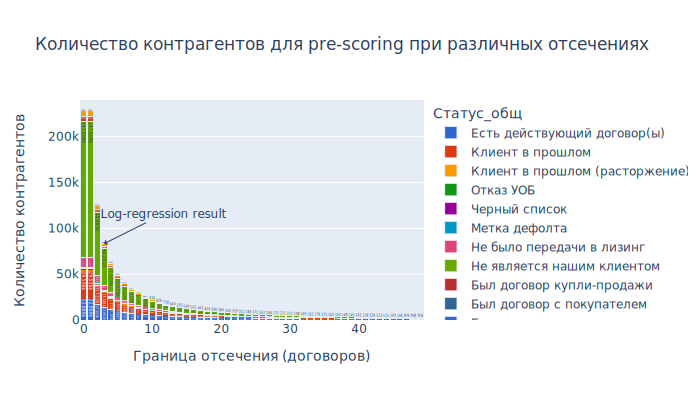

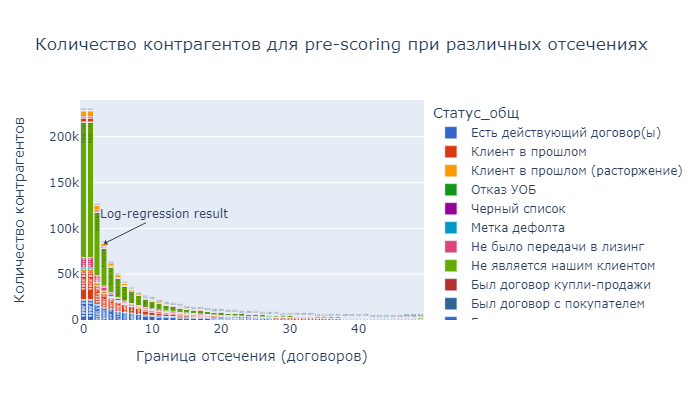

In [88]:
fig_clients_versus_boundary = show_clients_for_prescoring(clients_w_metrics, 'Статус_общ', annot_boundary=3)
fig_clients_versus_boundary.write_html(pre+'data/html/clients-pre.html')


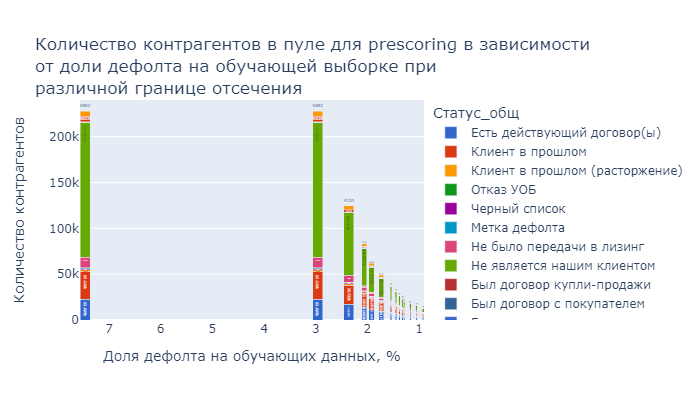

In [89]:
clients_w_metrics_round = clients_w_metrics.sort_values(by=['Процент_дефолта_в_target', 'Статус_общ',  'boundary']).drop_duplicates(subset=['Процент_дефолта_в_target', 'Статус_общ'])
clients_w_metrics_round = clients_w_metrics_round[clients_w_metrics_round['boundary']<15]
df = pd.pivot_table(clients_w_metrics_round, index=['Статус_общ', 'Процент_дефолта_в_target', 'boundary'], values='Количество ИНН', aggfunc='sum').reset_index()

fig_prob_share = show_clients_versus_metric(df, X='Процент_дефолта_в_target', x_lable='Доля дефолта на обучающих данных, %', 
                                    title='Количество контрагентов в пуле для prescoring в зависимости' + '<br>' + 'от доли дефолта на обучающей выборке при '
                                    + '<br>' + 'различной границе отсечения')
fig_prob_share.update_traces(width = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.1, 0.1, 0.1,0.2, 0.2, 0.2, 0.2])
fig_prob_share.update_xaxes(tick0=0, dtick=1)
fig_prob_share.update_xaxes(autorange="reversed")
fig_prob_share.show('png' if need_svg else '')

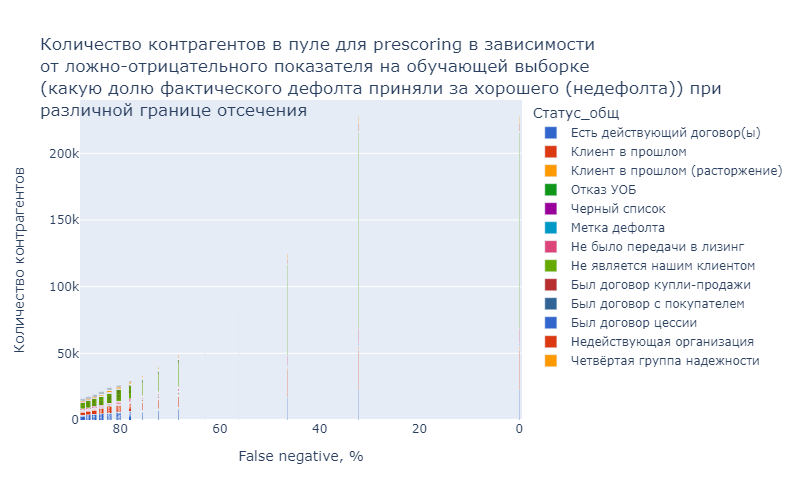

In [90]:
clients_w_metrics_round = clients_w_metrics.sort_values(by=['FN_percent', 'Статус_общ',  'boundary']).drop_duplicates(subset=['FN_percent', 'Статус_общ'])
clients_w_metrics_round = clients_w_metrics_round[clients_w_metrics_round['boundary']<15]
df = pd.pivot_table(clients_w_metrics_round, index=['Статус_общ', 'FN_percent', 'boundary'], values='Количество ИНН', aggfunc='sum').reset_index()
fig_FN = show_clients_versus_metric(df, X='FN_percent', x_lable='False negative, %', 
            title='Количество контрагентов в пуле для prescoring в зависимости' + '<br>' + 'от ложно-отрицательного показателя на обучающей выборке' + '<br>' +
            '(какую долю фактического дефолта приняли за хорошего (недефолта)) при' 
             + '<br>' + 'различной границе отсечения')
fig_FN.update_traces(width = [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.5, 1, 1, 1, 1, 1, 1])
fig_FN.update_xaxes(autorange="reversed")
fig_FN.update_layout(autosize=False, width=800, height=500,)
fig_FN.show('png' if need_svg else '')

### распределение лизингополучателей при boundary = 4

Качество при отсечении количества договоров от 4 и более 
 
 
 
 boundary 
 FN 
 TN 
 FP 
 TP 
 Доля_дефолта_в_target 
 
 
 
 
 4 
 4.0 
 0.630471 
 0.910365 
 0.089635 
 0.369529 
 0.019172

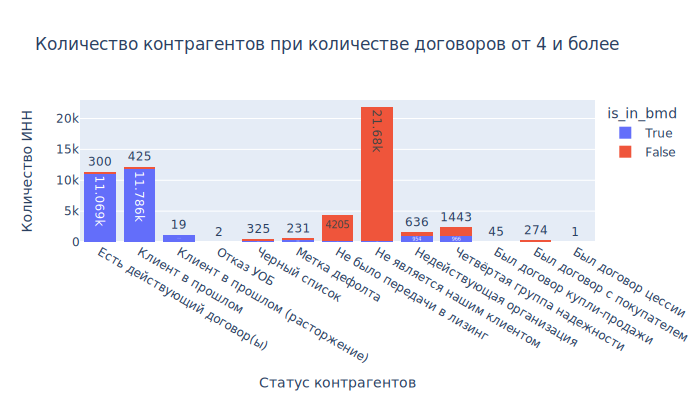

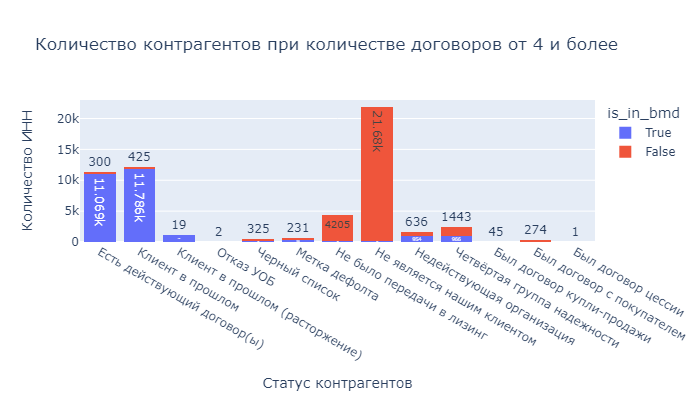

In [91]:
boundary = 4

tmp = df_metrics[df_metrics['boundary']==boundary][['boundary', 'FN', 'TN', 'FP', 'TP', 'Доля_дефолта_в_target']]
metrics_4 = html_side_by_side(tmp, titles=['Качество при отсечении количества договоров от 4 и более'])
display_html(metrics_4, raw=True)

mask = (clients['no_contracts_total']>=boundary)
df = clients[mask]

fig_boundary_4 = show_clients_boundary_fix(df, title = "Количество контрагентов при количестве договоров от 4 и более")
fig_boundary_4.write_html(pre+'data/html/boundary4.html')

## Сохранение результатов

In [92]:
good_clients = clients[clients['Статус_общ'].isin(['Не является нашим клиентом', 'Есть действующий договор(ы)', 'Клиент в прошлом', 'Не было передачи в лизинг'])].copy()

for boundary in [3, 4, 5]:
    mask = (good_clients['no_contracts_total']>=boundary)
    df = good_clients[mask]
    print(boundary, df.shape)
    df[['new_lessee_inn', 'Статус_общ', 'is_in_bmd']].to_pickle(pre+"data/processed/boundary_{}.pkl".format(boundary), compression={'method':'zip'})
    df[['new_lessee_inn', 'Статус_общ', 'is_in_bmd']].to_csv(pre+"data/processed/boundary_{}.csv".format(boundary), index=False)

3 (74978, 7)
4 (55270, 7)
5 (43359, 7)


In [93]:
list_of_fig = [fig_clients_versus_boundary,  fig_predictions, fig_prob_share, fig_FN, 
                fig_boundary_4, metrics_4, fig_roc_auc, fig_FP_TP, fig_FN_TN]
for fig in list_of_fig:
    if (fig == fig_roc_auc):
        continue
    if isinstance(fig, str):
        continue

    fig.update_layout(autosize=False, width=1500, height=600,)

combine_plotly_figs_to_html(list_of_fig, pre+'data/html/prescoring.html')

### сохраним трейнdata и mdm

In [94]:
target_frod.data['no_contracts_total'].to_pickle(pre+"data/processed/no_contracts_total.pkl", compression={'method':'zip'})
target_frod.data['Метка дефолта'].to_pickle(pre+"data/processed/метка_дефолта.pkl", compression={'method':'zip'})

In [95]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()

In [96]:
#  проверка в ручную некоторых
boundary= 4
mask = (good_clients['no_contracts_total']>=boundary)
df = good_clients[mask]
print(boundary, df.shape)
# df[df['Статус_общ']=='Не было передачи в лизинг'][['new_lessee_inn', 'Статус_общ', 'is_in_bmd']]

4 (55270, 7)
